In [1]:
import sys
import os

sys.path.append('../')

In [2]:
from Unlearner.DPLRUnlearner import DPLRUnlearner
from Applications.FeatureUnlearning.LinearEnsembleExperiments import split_train_data, create_models
from Applications.FeatureUnlearning.DataLoader import DataLoader
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import warnings
warnings.filterwarnings("ignore")

2025-11-10 02:28:34.985931: I tensorflow/core/util/port.cc:153] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-11-10 02:28:34.992809: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:467] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1762741715.001393  627902 cuda_dnn.cc:8579] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1762741715.003975  627902 cuda_blas.cc:1407] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
W0000 00:00:1762741715.010193  627902 computation_placer.cc:177] computation placer already registered. Please check linkage and avoid linking 

In [3]:
import tensorflow as tf

# 方法1：检查默认设备
print("=== 默认设备信息 ===")
print("TensorFlow 版本:", tf.__version__)
print("GPU 设备列表:", tf.config.list_physical_devices('GPU'))
print("CPU 设备列表:", tf.config.list_physical_devices('CPU'))

# 方法2：创建一个简单计算并检查设备位置
print("\n=== 设备分配测试 ===")
with tf.device('/GPU:0'):  # 明确指定使用第一个 GPU
    a = tf.constant([[1.0, 2.0], [3.0, 4.0]])
    b = tf.constant([[1.0, 1.0], [0.0, 1.0]])
    c = tf.matmul(a, b)
    print(f"矩阵乘法结果: {c}")
    print(f"张量所在设备: {c.device}")

# 方法3：性能测试对比
print("\n=== GPU 加速验证 ===")
import time

def test_gpu_performance():
    size = 5000
    # 在 GPU 上执行
    with tf.device('/GPU:0'):
        a_gpu = tf.random.normal([size, size])
        b_gpu = tf.random.normal([size, size])
        start_time = time.time()
        c_gpu = tf.matmul(a_gpu, b_gpu)
        gpu_time = time.time() - start_time
        print(f"GPU 计算耗时: {gpu_time:.4f} 秒")
    
    return gpu_time

test_gpu_performance()

=== 默认设备信息 ===
TensorFlow 版本: 2.19.1
GPU 设备列表: [PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU'), PhysicalDevice(name='/physical_device:GPU:1', device_type='GPU')]
CPU 设备列表: [PhysicalDevice(name='/physical_device:CPU:0', device_type='CPU')]

=== 设备分配测试 ===
矩阵乘法结果: [[1. 3.]
 [3. 7.]]
张量所在设备: /job:localhost/replica:0/task:0/device:GPU:0

=== GPU 加速验证 ===
GPU 计算耗时: 0.0031 秒


I0000 00:00:1762741718.170304  627902 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:0 with 22440 MB memory:  -> device: 0, name: NVIDIA GeForce RTX 3090, pci bus id: 0000:01:00.0, compute capability: 8.6
I0000 00:00:1762741718.170637  627902 gpu_device.cc:2019] Created device /job:localhost/replica:0/task:0/device:GPU:1 with 2688 MB memory:  -> device: 1, name: NVIDIA GeForce RTX 3080, pci bus id: 0000:07:00.0, compute capability: 8.6


0.0031244754791259766

### Certified Unlearning

We firstly show some examples on the linear classifier with certification guarantees. Firstly, how large is the gradient residual for different unlearning algorithms and what accuracy does a classifier achieve that has noise that corresponds to this gradient residual?

In [4]:
dataset_name = 'Enron'  # we use the spam dataset as an example
normalize = True  # we normalize the datapoints to have euclidean norm of 1
# load the training and test data
loader = DataLoader(dataset_name, normalize)
train_data, test_data, voc = (loader.x_train, loader.y_train), (loader.x_test, loader.y_test), loader.voc
category_to_idx_dict = loader.category_to_idx_dict
# create folders for results
res_save_folder = 'Results_{}'.format(dataset_name)
model_save_folder = 'Models_{}'.format(dataset_name)
if not os.path.isdir(res_save_folder):
    os.makedirs(res_save_folder)
# relevant features contain the privacy sensitive features of the dataset, (names in the case of Enron)
relevant_features = loader.relevant_features
relevant_indices = [voc[f] for f in relevant_features]
# lets see some names that were found in the dataset
print(','.join(relevant_features[:10]))
# these features will be deleted
indices_to_delete = relevant_indices

adams,afford,alan,allen,anderson,anthony,arnold,arthur,austin,barry


In [5]:
from Applications.FeatureUnlearning.LRExperiments import get_average_gradient_residual

# What is the gradient residual and which accuracy do we achieve when we set epsilon=0.1 and want to certify the unlearning?

lambda_ = 1.0  # regularization strength
sigma = 0.0  # noise to compute gradient residual
combination_lengths = [10,50,100] # we remove 10,50,100 names  随机抽取10组不同的特征组合，每组包含100个特征
n_combinations = 10 # we sample 10 combinations of [10,50,100] features to remove
unlearning_rate = 0.0001 # First Order update unlearning rate
unlearning_rate_ft = unlearning_rate # learning rate for fine-tuning
iter_steps = 10 # for comparison, we also split up the removal into 10 single steps
remove = True # we really remove the features from the dataset

In [6]:
import os
os.environ["OMP_NUM_THREADS"] = "1"
os.environ["OPENBLAS_NUM_THREADS"] = "1"
os.environ["MKL_NUM_THREADS"] = "1"
os.environ["VECLIB_MAXIMUM_THREADS"] = "1"
os.environ["NUMEXPR_NUM_THREADS"] = "1"



Sampling 10 combinations of 10 features ...


100%|██████████| 10/10 [00:38<00:00,  3.87s/it]


Saved results in Results_Enron/grad_residual_lambda=1.0_sigma=0.0_comb_len=10_ULR=0.0001
Gradient Residuals for methods ['DP', 'Finetuning', '1st-Order', '2nd-Order', 'WDP-only']
Mean residual: [np.float64(3.0065894171424135), np.float64(2.8715412434934366), np.float64(2.978984684406096), np.float64(0.011441249682691602), np.float64(3.00856158889593)]
Std  residual: [np.float64(1.617066347646081), np.float64(1.4521771045712992), np.float64(1.5957556527368137), np.float64(0.00512515051020814), np.float64(1.6161140550732567)]
Sigmas for certification: [np.float64(95.17776863044689), np.float64(90.90263091053056), np.float64(94.30390243158968), np.float64(0.3621886676423482), np.float64(95.24020046958843)]
Retraining from scratch achieved accuracy of 0.9848013048635824
SISA achieved accuracy of 0.9634193357058127
Retraining model with resulting sigma from DP for 100 times ...


100%|██████████| 100/100 [00:28<00:00,  3.52it/s]


DP achieved avg accuracy of 0.7309252669039146 (min 0.3569098457888493, max 0.849644128113879).
DP achieved avg macro f1 score of 0.7248356203890103.
DP achieved weighted f1 score of 0.7251968462844445.
Retraining model with resulting sigma from Finetuning for 100 times ...


100%|██████████| 100/100 [00:29<00:00,  3.41it/s]


Finetuning achieved avg accuracy of 0.7173887900355871 (min 0.4887307236061684, max 0.8675860023724793).
Finetuning achieved avg macro f1 score of 0.7055487860892384.
Finetuning achieved weighted f1 score of 0.7057202083758735.
Retraining model with resulting sigma from 1st-Order for 100 times ...


100%|██████████| 100/100 [00:28<00:00,  3.48it/s]


1st-Order achieved avg accuracy of 0.7372153024911033 (min 0.5051897983392646, max 0.8647686832740213).
1st-Order achieved avg macro f1 score of 0.7311471145773598.
1st-Order achieved weighted f1 score of 0.7311634910740473.
Retraining model with resulting sigma from 2nd-Order for 100 times ...


100%|██████████| 100/100 [00:57<00:00,  1.74it/s]


2nd-Order achieved avg accuracy of 0.9830871886120995 (min 0.9816132858837485, max 0.984282325029656).
2nd-Order achieved avg macro f1 score of 0.9830525878124974.
2nd-Order achieved weighted f1 score of 0.9830793821993563.
Retraining model with resulting sigma from WDP-only for 100 times ...


100%|██████████| 100/100 [00:28<00:00,  3.53it/s]

WDP-only achieved avg accuracy of 0.7276527283511268 (min 0.35898576512455516, max 0.8813760379596679).
WDP-only achieved avg macro f1 score of 0.723628649527523.
WDP-only achieved weighted f1 score of 0.7237752021524233.


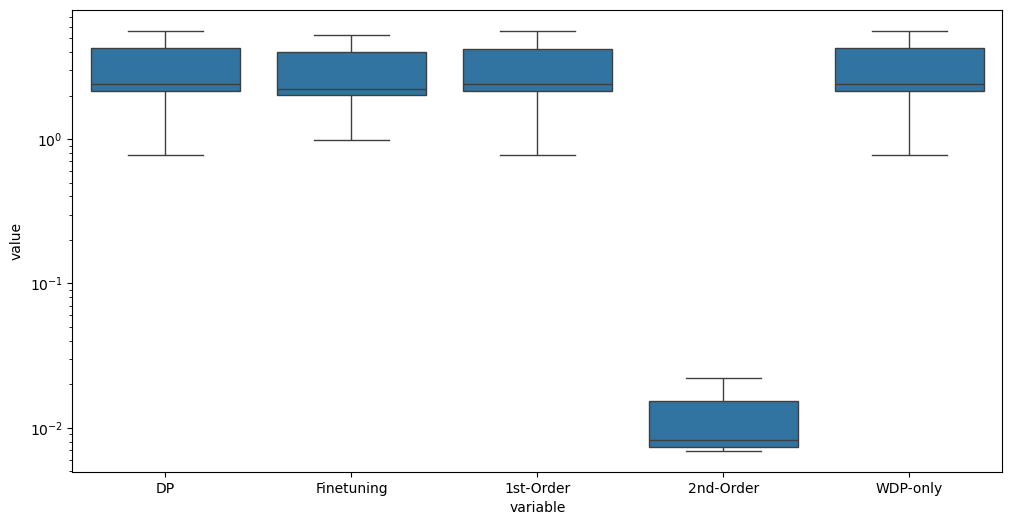


Sampling 10 combinations of 50 features ...


100%|██████████| 10/10 [00:39<00:00,  3.98s/it]


Saved results in Results_Enron/grad_residual_lambda=1.0_sigma=0.0_comb_len=50_ULR=0.0001
Gradient Residuals for methods ['DP', 'Finetuning', '1st-Order', '2nd-Order', 'WDP-only']
Mean residual: [np.float64(11.334442311590433), np.float64(11.059519695447687), np.float64(11.17563320103402), np.float64(0.2098264020669927), np.float64(11.332683506574082)]
Std  residual: [np.float64(9.143691883413236), np.float64(9.074882148468177), np.float64(8.977594917563025), np.float64(0.3122758247428647), np.float64(9.142830451573591)]
Sigmas for certification: [np.float64(358.8075317956202), np.float64(350.10447410462984), np.float64(353.7802085785674), np.float64(6.6423465188247865), np.float64(358.7518543772278)]
Retraining from scratch achieved accuracy of 0.9841637010676155
SISA achieved accuracy of 0.949703440094899
Retraining model with resulting sigma from DP for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


DP achieved avg accuracy of 0.6035157176749704 (min 0.498220640569395, max 0.7157473309608541).
DP achieved avg macro f1 score of 0.5620430273013434.
DP achieved weighted f1 score of 0.5620436307709974.
Retraining model with resulting sigma from Finetuning for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Finetuning achieved avg accuracy of 0.6049065836298932 (min 0.4940688018979834, max 0.733540925266904).
Finetuning achieved avg macro f1 score of 0.5624978313397803.
Finetuning achieved weighted f1 score of 0.5613794194115723.
Retraining model with resulting sigma from 1st-Order for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.91it/s]


1st-Order achieved avg accuracy of 0.611958778173191 (min 0.48546856465005933, max 0.755338078291815).
1st-Order achieved avg macro f1 score of 0.5767163608232798.
1st-Order achieved weighted f1 score of 0.5763273463491897.
Retraining model with resulting sigma from 2nd-Order for 100 times ...


100%|██████████| 100/100 [00:52<00:00,  1.91it/s]


2nd-Order achieved avg accuracy of 0.9184000593119809 (min 0.9110320284697508, max 0.9268979833926453).
2nd-Order achieved avg macro f1 score of 0.9183019493611585.
2nd-Order achieved weighted f1 score of 0.9184005584338836.
Retraining model with resulting sigma from WDP-only for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


WDP-only achieved avg accuracy of 0.6079314946619218 (min 0.5038552787663108, max 0.7230130486358244).
WDP-only achieved avg macro f1 score of 0.5729345165790131.
WDP-only achieved weighted f1 score of 0.572942605039077.


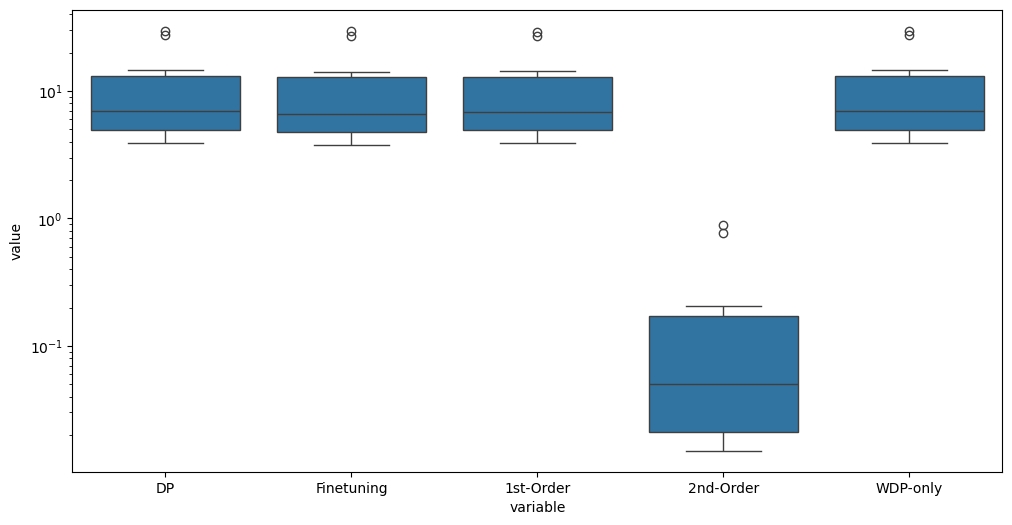


Sampling 10 combinations of 100 features ...


100%|██████████| 10/10 [00:41<00:00,  4.12s/it]


Saved results in Results_Enron/grad_residual_lambda=1.0_sigma=0.0_comb_len=100_ULR=0.0001
Gradient Residuals for methods ['DP', 'Finetuning', '1st-Order', '2nd-Order', 'WDP-only']
Mean residual: [np.float64(21.38565373458206), np.float64(21.16253123983048), np.float64(21.066839346798034), np.float64(0.7190130165216693), np.float64(21.382716666639237)]
Std  residual: [np.float64(14.034776764500387), np.float64(13.925170439779594), np.float64(13.760118730040471), np.float64(0.704946882369705), np.float64(14.031392021080896)]
Sigmas for certification: [np.float64(676.9926054936589), np.float64(669.9293526728271), np.float64(666.9000927403193), np.float64(22.761356817992684), np.float64(676.8996285239668)]
Retraining from scratch achieved accuracy of 0.983214709371293
SISA achieved accuracy of 0.9204922894424673
Retraining model with resulting sigma from DP for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


DP achieved avg accuracy of 0.5710231316725979 (min 0.47701660735468565, max 0.6628113879003559).
DP achieved avg macro f1 score of 0.5474857277000875.
DP achieved weighted f1 score of 0.5476658455645002.
Retraining model with resulting sigma from Finetuning for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


Finetuning achieved avg accuracy of 0.5706094306049821 (min 0.4610023724792408, max 0.6766014234875445).
Finetuning achieved avg macro f1 score of 0.5441169971283123.
Finetuning achieved weighted f1 score of 0.5435768181304994.
Retraining model with resulting sigma from 1st-Order for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


1st-Order achieved avg accuracy of 0.5725889679715301 (min 0.5011862396204033, max 0.6887603795966786).
1st-Order achieved avg macro f1 score of 0.5507637898934393.
1st-Order achieved weighted f1 score of 0.5505268280546468.
Retraining model with resulting sigma from 2nd-Order for 100 times ...


100%|██████████| 100/100 [00:41<00:00,  2.39it/s]


2nd-Order achieved avg accuracy of 0.8490213523131671 (min 0.8337781731909846, max 0.868920521945433).
2nd-Order achieved avg macro f1 score of 0.848898579116581.
2nd-Order achieved weighted f1 score of 0.8490464996386967.
Retraining model with resulting sigma from WDP-only for 100 times ...


100%|██████████| 100/100 [00:16<00:00,  5.92it/s]


WDP-only achieved avg accuracy of 0.569802787663108 (min 0.4749406880189798, max 0.6561387900355872).
WDP-only achieved avg macro f1 score of 0.5478860017650132.
WDP-only achieved weighted f1 score of 0.5482498326296565.


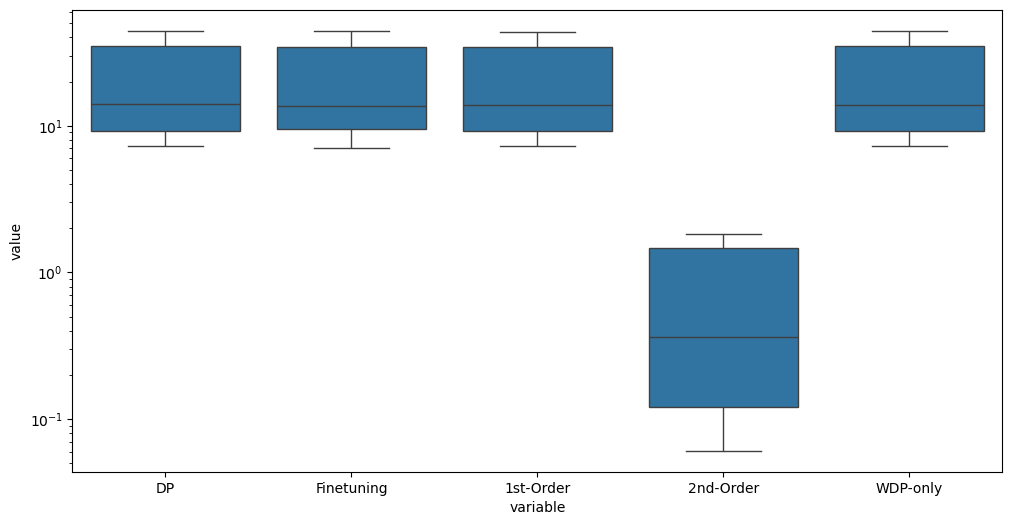

In [7]:
get_average_gradient_residual(train_data, test_data, voc, lambda_, sigma, indices_to_delete,
                            combination_lengths, n_combinations, unlearning_rate, unlearning_rate_ft,
                            iter_steps, category_to_idx_dict, remove=remove, n_replacements=0, save_path=res_save_folder, wdp_target_epsilon=3.81, wdp_mu=2.0)

### Results

We see that the gradient residual of the second order is by far the smallest and the gradient residual is always increasing when we increase the number of features to be deleted. In terms of accuracy, the second order update remains close to retraining when the number of features removed is not too high.

### Fidelity Evaluation

How do the unlearning strategies impact the classifier? We give an example of a scatter plot used in the paper to measure the difference between unlearning and retraining (here sigma=0) using the difference in test loss to get a better understanding of the fidelity each method yields.

url::http://schemas.android.com/apk/res/,url::r.admob.com,url::http://r.admob.com/ad_source.php,url::http://mm.admob.com/static/android/canvas.html,url::http://mm.admob.com/static/android/i18n/20100820,url::http://api.admob.com/v1/pubcode/android_sdk_emulator_notice,url::http://a.admob.com/f0?,url::mm.admob.com,url::api.admob.com,url::a.admob.com


100%|██████████| 30/30 [00:52<00:00,  1.75s/it]

Saved results at ./scatter_losses-combinations-20-lambda-1.0-sigma-0.0-top-140.npy
[scatter_plot] results shape=(7, 30)


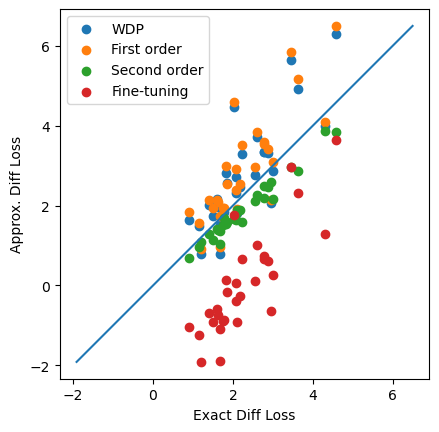

In [6]:
from Applications.FeatureUnlearning.LRExperiments import scatter_experiments
from Applications.FeatureUnlearning.LRExperiments import find_most_relevant_indices

dataset_name = 'Drebin'  # we use the malware dataset as an example
normalize = True  # we normalize the datapoints to have euclidean norm of 1
# load the training and test data
loader = DataLoader(dataset_name, normalize)
train_data, test_data, voc = (loader.x_train, loader.y_train), (loader.x_test, loader.y_test), loader.voc
category_to_idx_dict = loader.category_to_idx_dict
# create folders for results
res_save_folder = 'Results_{}'.format(dataset_name)
model_save_folder = 'Models_{}'.format(dataset_name)
if not os.path.isdir(res_save_folder):
    os.makedirs(res_save_folder)
# relevant features contain the privacy sensitive features of the dataset, (names in the case of Enron)
relevant_features = loader.relevant_features
relevant_indices = [voc[f] for f in relevant_features]
# lets see some names that were found in the dataset
print(','.join(relevant_features[:10]))
#
combination_length = 20
most_important_size = 300
n_combinations = 30
unlearning_rate = 0.001 # First Order update unlearning rate
unlearning_rate_ft = 0.0001 # learning rate for fine-tuning
# here, we mix in important features such that the effect is stronger
top_indices, _ = find_most_relevant_indices(train_data, test_data, voc, top_n=most_important_size)
indices_to_delete = np.intersect1d(top_indices, relevant_indices)

scatter_experiments(train_data, test_data, voc, lambda_, sigma, indices_to_delete, combination_length,
                   unlearning_rate, unlearning_rate_ft, n_combinations, category_to_idx_dict,
                   remove,
                   wdp_target_epsilon=3.81,  # 开启 WDP baseline
                   wdp_mu=2.0)



### Results

The identiy line is optimal in this plot, i.e. the second order update gives again the best results. Although the difference seems small, recall that the loss is a very sensitive metric to measure differences.